# Basic Exploratory Data Analysis

In this notebook I will demonstrate how to download the data and how to visualise one trip. The import statements can be seen as a default for the jupyter notebook in the cookiecutter environment. If you only want to download all the data call:

``python src\data\make_data.py``

In [1]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import load_dotenv, find_dotenv

import pandas as pd
import numpy as np

#Visualisation Libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
from datetime import datetime
#####
#
# Default way of appending the src directory in the cookiecutter file structure
#
#####

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

   
# import my method from the source code
%aimport data.download
from data.download import DatasetDownloader
%aimport visualization.visualize
from visualization.visualize import plot_track
from visualization.visualize import plot_gps_heatmap
%aimport data.preprocessing
from data.preprocessing import Preprocessor

# By loading the dotenv we can access Environment variables setted int the dm_mobility_task/.env file
# e.g. I setted there my token like this: "KEY_LUKAS"=1234, similary there is one for KEY_RAPHAEL and KEY_MORITZ
load_dotenv(find_dotenv())
DatasetDownloader.URL = str(os.environ.get("URL"))
DatasetDownloader.USERNAME = str(os.environ.get("LOGINNAME"))
DatasetDownloader.PASSWORD = str(os.environ.get("LOGINPASSWORD"))

In [2]:
# the environment variable specified in .env
# lists the recorded data by user
token = os.environ.get("KEY_RAPHAEL")
recorded_trips = DatasetDownloader.list_recorded_data(token)
recorded_trips

,full_name,last_modified,size
0,358568053229914_20171121-144912,2017-11-21 15:00,82K
1,358568053229914_20171121-145403,2017-11-21 15:00,122K
2,358568053229914_20171127-181845,2017-11-27 18:40,605K
3,358568053229914_20171128-130428,2017-11-28 18:00,173K
4,358568053229914_20171128-163426,2017-11-28 18:00,638K
5,358568053229914_20171128-174241,2017-11-28 18:00,707K
6,358568053229914_20171130-110040,2017-11-30 11:20,647K
7,358568053229914_20171201-133422,2017-12-01 14:10,279K
8,358568053229914_20171202-201423,2017-12-02 20:40,945K
9,358568053229914_20171203-124740,2017-12-03 13:30,229K


In order to avoid too many request to the server we can use the **full_name** column to download the data and save it to data/raw, but download_data_sets(token) can also download the data per token, or all data from our team can be downloaded with download_all().

In [6]:
# download_data_sets(token) works as well, 
# but than list_recorded_data is invoked again
# we can also download all data for our team by 
DatasetDownloader.download_all()
tar_file_names = list(recorded_trips["full_name"] + ".csv.tar.gz")
#download_data_sets(token, file_names=tar_file_names)

Downloaded  358568053229914_20171121-144912.csv.tar.gz
Downloaded  358568053229914_20171121-145403.csv.tar.gz
Downloaded  358568053229914_20171127-181845.csv.tar.gz
Downloaded  358568053229914_20171128-130428.csv.tar.gz
Downloaded  358568053229914_20171128-163426.csv.tar.gz
Downloaded  358568053229914_20171128-174241.csv.tar.gz
Downloaded  358568053229914_20171130-110040.csv.tar.gz
Downloaded  358568053229914_20171201-133422.csv.tar.gz
Downloaded  358568053229914_20171202-201423.csv.tar.gz
Downloaded  358568053229914_20171203-124740.csv.tar.gz
Downloaded  358568053229914_20171203-125830.csv.tar.gz
Downloaded  358568053229914_20171203-131254.csv.tar.gz
Downloaded  358568053229914_20171204-122532.csv.tar.gz
Downloaded  358568053229914_20171205-174655.csv.tar.gz
Downloaded  358568053229914_20171207-080914.csv.tar.gz
Downloaded  358568053229914_20171207-112509.csv.tar.gz
Downloaded  358568053229914_20171207-114522.csv.tar.gz
Downloaded  358568053229914_20171208-154843.csv.tar.gz
Downloaded

The data has now been downloaded in dm_mobility_task/data/raw/token, we can check that by calling:

In [7]:
# also possible for specific token
# get_file_names(os.path.join(get_data_dir(),"raw"), token=token)
recorded_file_names = DatasetDownloader.get_file_names(os.path.join(DatasetDownloader.get_data_dir(),"raw"))
print("We have recorded: {} trips".format(len(recorded_file_names)))
recorded_file_names

We have recorded: 118 trips


['358568053229914/358568053229914_20171201-133422.csv.tar.gz',
 '358568053229914/358568053229914_20171221-084642.csv.tar.gz',
 '358568053229914/358568053229914_20171214-074726.csv.tar.gz',
 '358568053229914/358568053229914_20180110-084624.csv.tar.gz',
 '358568053229914/358568053229914_20171214-112909.csv.tar.gz',
 '358568053229914/358568053229914_20171210-135927.csv.tar.gz',
 '358568053229914/358568053229914_20171213-135912.csv.tar.gz',
 '358568053229914/358568053229914_20171212-155714.csv.tar.gz',
 '358568053229914/358568053229914_20171213-132948.csv.tar.gz',
 '358568053229914/358568053229914_20180104-124518.csv.tar.gz',
 '358568053229914/358568053229914_20171127-181845.csv.tar.gz',
 '358568053229914/358568053229914_20171209-210436.csv.tar.gz',
 '358568053229914/358568053229914_20171128-163426.csv.tar.gz',
 '358568053229914/358568053229914_20171221-095226.csv.tar.gz',
 '358568053229914/358568053229914_20180110-091406.csv.tar.gz',
 '358568053229914/358568053229914_20171218-085853.csv.t

Now that the data has been downloaded, we can read it from file and start to explore it. I will here only explore data from my key, but with get_data_per_trip(dir_name="raw") it is possible to load all **raw** data per trip in memory.

In [8]:
from data.preprocessing import Preprocessor as pc
# read data per trip by for all users by invoking: get_data_per_trip(dir_name="raw")
dfs=pc.get_data_per_trip(dir_name="raw")
#dfs = Preprocessor.get_data_per_token('868049020858898')

In [9]:
sensor_data = dfs[0]['sensor']
acc = sensor_data[sensor_data['sensor'] == 'acceleration']
acc = acc.drop(['sensor', 'total'], axis=1)

# NECESSARY!!!!!!!
acc.reset_index(drop=True,inplace=True)

In [10]:
len(dfs)

118

In [8]:
acc

,time,x,y,z
0,1513105093921,-1.393341,4.315353,8.129410
1,1513105093927,-1.517776,4.553436,9.053040
2,1513105093933,-1.562042,4.658722,9.233704
3,1513105093943,-1.443588,4.772369,9.365311
4,1513105093953,-1.335922,4.801086,9.449051
5,1513105093963,-1.303619,4.893219,9.293518
6,1513105093975,-1.277298,4.993713,8.989639
7,1513105093983,-1.258148,5.035583,8.645065
8,1513105093993,-1.326340,5.018829,8.611572
9,1513105094003,-1.477097,4.852539,8.787445


In [10]:
#sample=Preprocessor.approx_sensor(acc, 100)
#df = pd.DataFrame([ay,ax], columns=['test','lel'])


In [11]:
storage = list()
for frame in dfs:
    sensor_data = frame['sensor']
    acc = sensor_data[sensor_data['sensor'] == 'acceleration']
    acc = acc.drop(['sensor', 'total'], axis=1)
    # NECESSARY!!!!!!!
    acc.reset_index(drop=True,inplace=True)
    storage.append(Preprocessor.approx_sensor(acc, 20))

/home/raphael/Development/datamining/py3env/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:571: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


#### PAA ####

Requirements:
    1) pyts
    2) future
    3) scipy

1) prepare data

In [12]:
sensor_data = dfs[0]['sensor']
sensor_data = sensor_data[sensor_data['sensor'] == 'acceleration']
sensor_data.drop(['sensor', 'total'], axis=1)
# Necessary to reset index
sensor_data.reset_index(drop=True,inplace=True)
sensor_data.head()

,sensor,time,x,y,z,total
0,acceleration,1512131662419,-1.465,6.273,7.374,9.791457
1,acceleration,1512131662429,-1.264,6.253,7.556,9.888926
2,acceleration,1512131662439,-0.814,6.301,7.709,9.989689
3,acceleration,1512131662449,-0.402,6.273,8.016,10.186677
4,acceleration,1512131662459,-0.162,6.196,8.245,10.314878


2) interpolate data

In [13]:
new_sensor_data = Preprocessor.approx_sensor(sensor_data, 20)
new_sensor_data.head()

,time,total,x,y,z
0,1.512132e+12,9.791457,-1.465,6.273,7.374
1,1.512132e+12,10.357043,0.038,6.100,8.370
2,1.512132e+12,10.140280,0.229,5.775,8.332
3,1.512132e+12,10.152437,0.632,5.554,8.475
4,1.512132e+12,10.027934,0.699,5.420,8.408


check if 20 trips per second

In [14]:
print(datetime.fromtimestamp(new_sensor_data['time'][0] / 1e3))
print(datetime.fromtimestamp(new_sensor_data['time'][19] / 1e3))
print(datetime.fromtimestamp(new_sensor_data['time'][39] / 1e3))
print(datetime.fromtimestamp(new_sensor_data['time'][59] / 1e3))

2017-12-12 19:58:13.921000
2017-12-12 19:58:14.871000
2017-12-12 19:58:15.871000
2017-12-12 19:58:16.871000


3) perform PAA

In [14]:
paa_df = Preprocessor.normalize_trip(new_sensor_data)
paa_df.head()

/home/raphael/Development/datamining/py3env/lib/python3.5/site-packages/pyts/utils/utils.py:63: RuntimeWarning: overflow encountered in short_scalars
  return np.arange(array[0], array[1])


,time,total,x,y,z
0,1512131662519,10.093830,0.026600,5.824400,8.191800
1,1512131662769,10.006147,0.369400,5.738000,8.187800
2,1512131663019,10.021064,0.625618,5.771709,8.167255
3,1512131663269,10.031064,0.697700,5.787000,8.162200
4,1512131663519,10.053550,0.999200,5.677000,8.233800


4) check if distance is correct (now every entry should span a second)

In [18]:
print("paa_df has size:", len(paa_df))
print("second:",datetime.fromtimestamp(paa_df['time'][0] / 1e3))
print("second:",datetime.fromtimestamp(paa_df['time'][1] / 1e3))
print("second:",datetime.fromtimestamp(paa_df['time'][2] / 1e3))
print("second:",datetime.fromtimestamp(paa_df['time'][3] / 1e3))
print("second:",datetime.fromtimestamp(paa_df['time'][4] / 1e3))

paa_df has size: 2856
second: 2017-12-12 19:58:13.996000
second: 2017-12-12 19:58:14.221000
second: 2017-12-12 19:58:14.471000
second: 2017-12-12 19:58:14.721000
second: 2017-12-12 19:58:14.971000


5) optional: print PAA result

In [19]:
#plot_paa(np.array(new_sensor_data['x'].head(200)), window_size=20,output_size=None,overlapping=False,marker='o')

NameError: name 'plot_paa' is not defined

Dismiss dataframes w/o annotation and less than 10 minutes long (see https://github.com/univie-datamining-team3/assignment2/issues/7).

In [15]:
# 1. Get travel data per token, remove dataframes without annotations.
dfs = Preprocessor._remove_dataframes_without_annotation(dfs)

# 2. Remove trips less than 10 minutes long.
dfs = Preprocessor._remove_dataframes_by_duration_limit(dfs, 10 * 60)

The data can now be accessed in the following way. Enter one of the following valid names as key in the dictionary:


In [21]:
DatasetDownloader.VALID_NAMES

['annotation', 'cell', 'event', 'location', 'mac', 'marker', 'sensor']

E.g. for the sensor data:

In [16]:
trip_nr = 0
dfs[trip_nr]["sensor"].head(10)

,sensor,time,x,y,z,total
0,magnetic,1512131662419,78.000,-21.250,-55.750,98.201958
1,acceleration,1512131662419,-1.465,6.273,7.374,9.791457
2,magnetic,1512131662429,78.000,-21.250,-55.750,98.201958
3,acceleration,1512131662429,-1.264,6.253,7.556,9.888926
4,magnetic,1512131662439,78.000,-21.250,-55.750,98.201958
5,acceleration,1512131662439,-0.814,6.301,7.709,9.989689
6,magnetic,1512131662449,78.000,-21.250,-55.750,98.201958
7,acceleration,1512131662449,-0.402,6.273,8.016,10.186677
8,magnetic,1512131662459,78.000,-21.250,-55.750,98.201958
9,acceleration,1512131662459,-0.162,6.196,8.245,10.314878


Get summaries for each recorded trip:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66e6e13278>]], dtype=object)

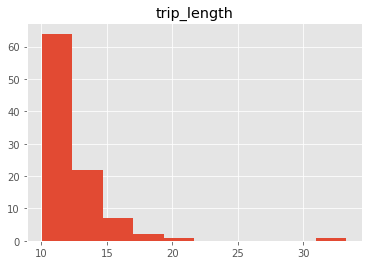

In [35]:
trip_summaries = Preprocessor.get_trip_summaries(dfs, convert_time=True)
trip_summaries['trip_length'] = pd.to_numeric(trip_summaries['trip_length']) / 1000000000 / 60.0
# Normalize trip lengths as minutes.
trip_summaries.hist()

Next we are visualizing the acceleration data:

In [36]:
acceleration_df = dfs[trip_nr]["sensor"]
acceleration_df = acceleration_df[acceleration_df["sensor"]=="acceleration"]
acceleration_df.head(3)

,sensor,time,x,y,z,total
1,acceleration,1512131662419,-1.465,6.273,7.374,9.791457
3,acceleration,1512131662429,-1.264,6.253,7.556,9.888926
5,acceleration,1512131662439,-0.814,6.301,7.709,9.989689


Quick visualisation of the acceleration of one of my trips

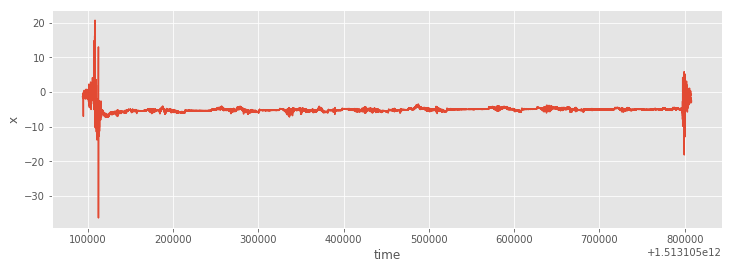

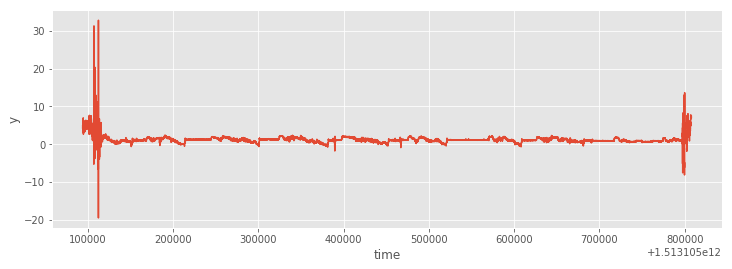

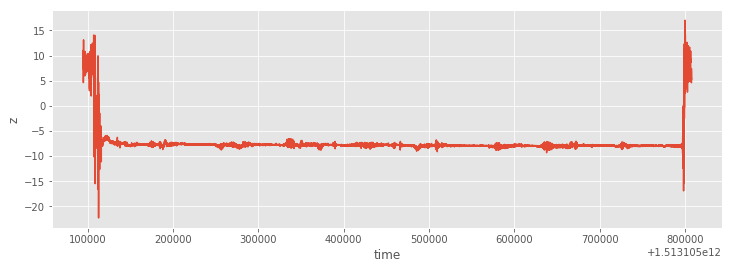

In [25]:
small = acceleration_df.drop(["sensor","total"],axis=1).set_index("time")
figsize=(12, 4)
small["x"].plot(figsize=figsize);
plt.ylabel("x")
plt.show();

small["y"].plot(figsize=figsize);
plt.ylabel("y")
plt.show();

small["z"].plot(figsize=figsize);
plt.ylabel("z")
plt.show();



**Plot the gps data on a google map and save it as html to disk:**

In [29]:
location_df = dfs[trip_nr]["location"]
file_name = "gps_test.html"
plot_track(location_df[["longitude", "latitude"]], file_name)

plot_gps_heatmap(location_df, "gps_heatmap.html")

TypeError: string indices must be integers

The track can now be viewed at:


In [13]:
os.path.join("reports","maps",file_name)

'reports/maps/gps_test.html'

----
**Apply resampling in new time interval for coarser granularity**

The following csv files include time columns: cell, event, location, marker, sensor.

Lets see an example for the acceleration data for one trip. First we have to convert the integer timestamps int the time column to datetime objects. This can be done via the convert_timestamps function.

In [14]:
acceleration_df = dfs[trip_nr]["sensor"]
acceleration_df = acceleration_df[acceleration_df["sensor"]=="acceleration"]
acceleration_df = Preprocessor.convert_timestamps(acceleration_df)
acceleration_df.head()

,time,sensor,x,y,z,total
1,2017-11-28 12:04:28.739,acceleration,0.584,4.472,9.510,10.525206
3,2017-11-28 12:04:28.749,acceleration,0.344,4.462,9.337,10.354098
5,2017-11-28 12:04:28.759,acceleration,0.229,4.328,9.203,10.172475
7,2017-11-28 12:04:28.769,acceleration,0.210,4.204,9.213,10.129023
9,2017-11-28 12:04:28.780,acceleration,0.258,4.261,9.308,10.240192


Next we can downsample the acceleration data from milliseconds to a 1 second interval, where the new aggregated values are aggregated via the mean. 

**Note** that this drops the sensor column and the sensor column has to be reappended. This is not an issue here because we have only one sensor type. If you want to keep the categorical variable, see next point.

In [15]:
acceleration_df_resampled = Preprocessor.downsample_time_series(acceleration_df, time_interval="1S")
acceleration_df_resampled.head()

,time,x,y,z,total
0,2017-11-28 12:04:28,0.365630,4.513222,9.034000,10.115174
1,2017-11-28 12:04:29,0.256859,4.704212,8.879000,10.057377
2,2017-11-28 12:04:30,0.747354,5.585434,8.308687,10.091584
3,2017-11-28 12:04:31,0.972111,5.143939,8.472747,10.073145
4,2017-11-28 12:04:32,0.562000,5.003900,8.719930,10.073243


Another possibility were we can keep all the categorical values is by using the downsample_time_series_per_category function, here shown for full sensor table.

**Note** that here we did not convert the time column for dfs[trip_nr] before, thats why this step is also done implicitly, otherwise the resampling does not work.

In [16]:
dfs[trip_nr]["sensor"].head()

,sensor,time,x,y,z,total
0,magnetic,1511870668739,-3.000,-25.250,13.500,28.789104
1,acceleration,1511870668739,0.584,4.472,9.510,10.525206
2,magnetic,1511870668749,-3.000,-25.250,13.500,28.789104
3,acceleration,1511870668749,0.344,4.462,9.337,10.354098
4,magnetic,1511870668759,-3.000,-25.250,13.500,28.789104


In [17]:
all_sensors_resampled = Preprocessor.downsample_time_series_per_category(dfs[trip_nr]["sensor"],
                                                                         categorical_colnames=["sensor"])

all_sensors_resampled.head()

,time,sensor,total,x,y,z
0,2017-11-28 12:04:28,magnetic,25.793018,-8.000000,-15.157407,17.666667
1,2017-11-28 12:04:28,acceleration,10.115174,0.365630,4.513222,9.034000
2,2017-11-28 12:04:29,acceleration,10.057377,0.256859,4.704212,8.879000
3,2017-11-28 12:04:29,magnetic,41.130451,-27.300505,5.419192,29.563131
4,2017-11-28 12:04:30,magnetic,63.605004,-45.252525,16.537879,41.502525


If we now once again plot the acceleration for the resampled version we get:

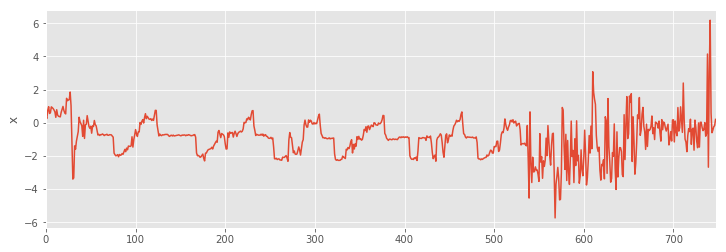

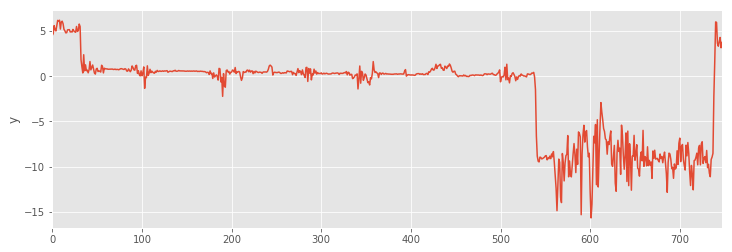

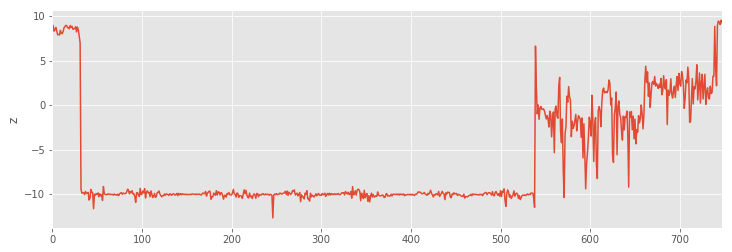

In [18]:
small = acceleration_df_resampled
figsize=(12, 4)
small["x"].plot(figsize=figsize);
plt.ylabel("x")
plt.show();

small["y"].plot(figsize=figsize);
plt.ylabel("y")
plt.show();

small["z"].plot(figsize=figsize);
plt.ylabel("z")
plt.show();